# Analyse channel 1 - 4
Here I will analyse the data of channel 1 - 4 from Alsdorf

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
from scipy import optimize
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from ipywidgets import interact
import ipywidgets as widgets
from copy import deepcopy#, copy
import statistics
#from random import randrange
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from shutil import copy2 as copy_file

import plotly
import plotly.express as px
import kaleido

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year
from my_func_mvw.functions import find_nearest_date, watertank_shift, calc_diff_between_channels, read_pickle, write_pickle, temp_watertank_func, check_first_last_date, calc_stat_of_difference, cut_dataframe_to_range_tlogger, check_processed_data, carpet_plot_with_gaps, add_nan_val_in_datagaps

plot_save=True #True False
fast_calc=False #True False

path_to_my_database = r"..\Alsdorf\Daten\my_database" #".\\"
importer = "pickle" #at the moment everything is imported with pickle

# TO DO
# andere kalibrationsmethoden offenes ende --> Literatur lesen
# knick in dämpfung noch bearbeiten
# Vergleich mit anderen Kanälen systematisch machen

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")
# pandas version: 1.2.3
# pickle version: 4.0

Some Version information of the imported packages
pandas version: 1.3.2
pickle version: 4.0


In [92]:
# Load pickle Data

#this variable only contains every 10s row, if using all data it would be over 2Gb.
if path_to_my_database == r"..\Alsdorf\Daten\my_database":
    data_ch14_constshifted = read_pickle(path_to_my_database + "\..\my_database_additional_local\data_ch1-4_processed_constshifted")
else:
    data_ch14_constshifted = read_pickle("data_ch1-4_processed_constshifted")

if fast_calc:
    for chan in ["1","2","3","4"]:
        data_ch14_constshifted[chan] = data_ch14_constshifted[chan][::10] #only use every 10th row

# final shaft temp old cable
shaft={}
for chan in ["1","2","3","4"]:
    shaft[chan] = read_pickle(path_to_my_database + f"\\shaft_final_temperature\\old_cable\\pickle\\Schacht_chan_{chan}")

# final shaft temp egrt cabel
filename=f"\\Schacht_7and8_down"
path_to_my_database_pickle = path_to_my_database + r"\shaft_final_temperature\egrt_cable\pickle"
Schacht_7and8_down = read_pickle(path_to_my_database_pickle + filename)

# Import TLogger
Im Moment sind im PT100 Datensatz alle Daten die ich habe. D.h. meine alten PT100 um 1.5 °C korigiert, ein paar Daten von Solexperts und die neuen PT1000 Daten.

In [93]:
# read csv
# Tlogger_PT1000 = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000.csv", index_col=[0])
# Tlogger_PT100  = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated.csv",index_col=[0])
# Tlogger_PT100.index.names=["Date"]; Tlogger_PT1000.index.names=["Date"]
# Tlogger_PT100.index = pd.to_datetime(Tlogger_PT100.index); Tlogger_PT1000.index = pd.to_datetime(Tlogger_PT1000.index)

#read_pickle
df_Tlogger_PT1000 = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000")
df_Tlogger_PT100  = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated")

watertank_T_range_min = df_Tlogger_PT100.index.min()
watertank_T_range_max = df_Tlogger_PT100.index.max()

df_Tlogger_PT100

Channel1-Watertank_PT100  Channel2-Air  \
2021-06-07 12:12:40                      23.4          25.8   
2021-06-07 12:13:40                      23.5          25.4   
2021-06-07 12:14:40                      23.4          25.2   
2021-06-07 12:15:40                      23.5          24.9   
2021-06-07 12:16:40                      23.5          24.8   
...                                       ...           ...   
2021-08-09 10:28:14                      20.6           NaN   
2021-08-09 10:31:14                      20.6           NaN   
2021-08-09 10:34:14                      20.6           NaN   
2021-08-09 10:37:13                      20.6           NaN   
2021-08-09 10:40:13                      20.6           NaN   

                     Channel1-PT100_rolling_mean  
2021-06-07 12:12:40                         23.5  
2021-06-07 12:13:40                         23.5  
2021-06-07 12:14:40                         23.5  
2021-06-07 12:15:40                         23.5  
2021-06-07 12:16:40                         23.5  
...                                          ...  
2021-08-09 10:28:14                         20.6  
2021-08-09 10:31:14                         20.6  
2021-08-09 10:34:14                         20.6  
2021-08-09 10:37:13                         20.6  
2021-08-09 10:40:13                         20.6  

[34966 rows x 3 columns]

# Compare EGRT Cable channel 1 - 4 to Wireline T-Logger 2020

In [94]:
# Load Wireline data
path_to_wireline = path_to_my_database + "\PTS_Logs"

filename2003=r"\PTS_2003.csv"
wireline_measurements2003 = pd.read_csv(path_to_wireline + filename2003,skiprows=[0,2,3],index_col=0,na_values=-999.0)
wireline_measurements2003.columns = ["BHT","CBLE_ACC","CURRENT","DIFF-TENSION0","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME","VOLTAGE"] #rename columns, because the original names contain empty spaces
wireline_measurements2003 = wireline_measurements2003.dropna()

filename2020=r"\PTS_20201124.csv"
wireline_measurements2020 = pd.read_csv(path_to_wireline + filename2020,index_col=0,skiprows=[0,2,3],na_values=-999.0)
wireline_measurements2020.columns = ["BHT","DEPTH.1","dPress","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME"]
wireline_measurements2020 = wireline_measurements2020.drop(columns=["DEPTH.1"]) # the same as DEPTH column
wireline_measurements2020 = wireline_measurements2020.dropna() # drop some nan rows

In [95]:
# Calc diff to wireline
diff_to_wireline = {}
shaft_data = pd.DataFrame(index=np.arange(160,576,1),columns=["dts chan 1","dts chan 2","dts chan 3","dts chan 4","wireline"])
shaft_data.index.names=["Depth"]

shaft_data["wireline"] = wireline_measurements2020["BHT"][160 : 575][::20].values #skip air and not trusted, only use datapoints every meter
for chan in ["1","2","3","4"]:
    date_name, date_iloc = find_nearest_date("2020-11-24 12:00:00",data_ch14_constshifted[chan].index)
    shaft_data[f"dts chan {chan}"] = data_ch14_constshifted[chan].loc[date_name][200 + 160: 575+201].values #skip first 200 and air and not trusted
    diff_to_wireline[chan] = shaft_data[f"dts chan {chan}"] - shaft_data["wireline"]

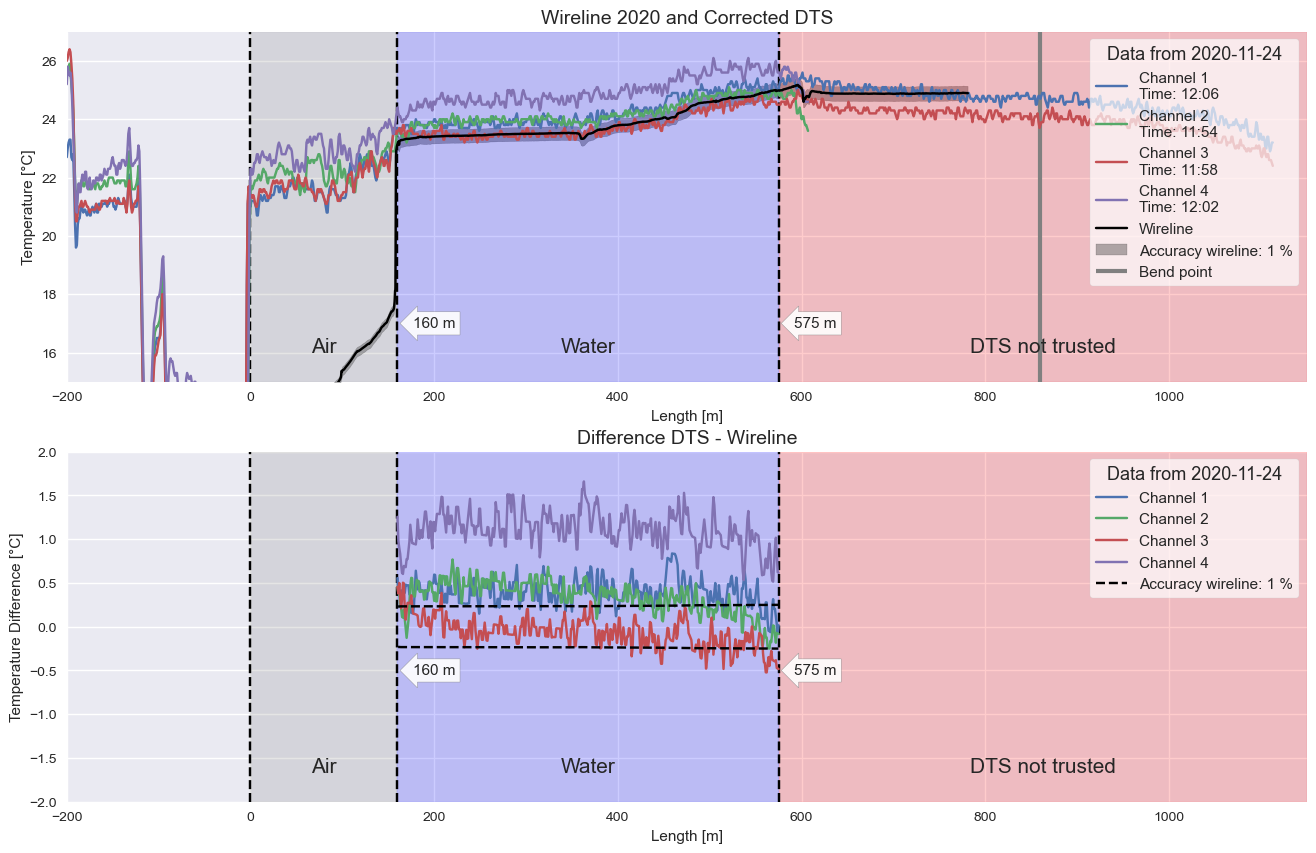

In [232]:
# compare shifted data to wireline
def color_cable_pos(start_len, end_len, col, ymax, ymin, label_name, axs, label=True):
    """ creates patches which color the plot"""
    width = end_len - start_len
    Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=(ymax-ymin),color=col,alpha=0.2)
    axs.add_patch(Rectangle)
    if label:
        #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
        bbox_props=dict(boxstyle="round",fc=col, ec="0.5", alpha=0.0)
        axs.text(start_len+width/2,ymax-(ymax-ymin)*0.1,label_name,ha="center",va="center",size=15,bbox=bbox_props)

begin_shaft = 200 # muss ich noch genauer nachgucken
fig, axs = plt.subplots(2,1,figsize=[16,10])

axs[0].set_title("Wireline 2020 and Corrected DTS", fontsize = 14)
axs[0].set_ylabel("Temperature [°C]")
ylim=[15,27]
axs[0].set_ylim(ylim)
for chan in ["1","2","3","4"]:
    date_name, date_iloc = find_nearest_date("2020-11-24 12:00:00",data_ch14_constshifted[chan].index)
    data=data_ch14_constshifted[chan].loc[date_name]
    axs[0].plot(data.index - begin_shaft,data.values,
                label=f"Channel {chan}\nTime: {date_name[11:-3]}") #\nTime: {date_name[11:-3]}
axs[0].plot(wireline_measurements2020["BHT"].index,wireline_measurements2020["BHT"].values,label="Wireline",color="black")
data=wireline_measurements2020["BHT"][::20] #original dataframe has every 5 cm a datapoint, 1 m is sufficient
axs[0].fill_between(data.index,data.values+0.01*data.values,data.values-0.01*data.values,color="black",alpha=0.3, 
                    label="Accuracy wireline: 1 %")
#color plot
axs[0].vlines([0,160,575],ylim[0],ylim[1],color="black",linestyle="--")
bbox_props = dict(boxstyle="larrow", fc="w", ec="0.5", alpha=0.9)
size=11; y=50; ha="center"; va="center"
axs[0].text(575 + 40, 17,"575 m", ha=ha, va=va, size=size, bbox=bbox_props)
axs[0].text(160 + 40, 17,"160 m", ha=ha, va=va, size=size, bbox=bbox_props)
color_cable_pos(575,1150,"red",ylim[0],ylim[1],"DTS not trusted",axs[0])
color_cable_pos(0,160,"gray",ylim[0],ylim[1],"Air",axs[0])
color_cable_pos(160,575,"blue",ylim[0],ylim[1],"Water",axs[0])

# Bend point
last_length={}
for channel in ["1","2","3","4"]:
    col=data_ch14_constshifted[channel].columns[begin_shaft:]
    last_length[channel] = data_ch14_constshifted[channel][col].columns.max() - begin_shaft
    #print(f"Channel {channel} shifted, last length {last_length[channel]}")
    #passt ziemlich genau zur Einbautiefe der Erdwärmesonde
bend_point=last_length["2"] + (last_length["1"] - last_length["2"]) / 2 
axs[0].vlines([bend_point],ylim[0],ylim[1],color="grey",label="Bend point", linewidth=3)

#####################################################################################

axs[1].set_ylabel("Temperature Difference [°C]")
axs[1].set_title("Difference DTS - Wireline", fontsize = 14)
ylim=[-2,2]
axs[1].set_ylim(ylim)
for chan in ["1","2","3","4"]:
    axs[1].plot(diff_to_wireline[chan],label=f"Channel {chan}")
data=wireline_measurements2020["BHT"][::20][160 : 575]
axs[1].plot(data.index,0.01*data.values,color="black",linestyle="--", label="Accuracy wireline: 1 %")
axs[1].plot(data.index,-0.01*data.values,color="black",linestyle="--")
#color plot
axs[1].vlines([0,160,575],ylim[0],ylim[1],color="black",linestyle="--")
bbox_props = dict(boxstyle="larrow", fc="w", ec="0.5", alpha=0.9)
size=11; y=50; ha="center"; va="center"
axs[1].text(575 + 40, -0.5,"575 m", ha=ha, va=va, size=size, bbox=bbox_props)
axs[1].text(160 + 40, -0.5,"160 m", ha=ha, va=va, size=size, bbox=bbox_props)
color_cable_pos(575,1150,"red",ylim[0],ylim[1],"DTS not trusted",axs[1])
color_cable_pos(0,160,"gray",ylim[0],ylim[1],"Air",axs[1])
color_cable_pos(160,575,"blue",ylim[0],ylim[1],"Water",axs[1])

for ax in axs:
    ax.set_xlim([-200,1150])
    ax.set_xlabel("Length [m]")
    legend = ax.legend(fontsize=11,title="Data from 2020-11-24", title_fontsize=11+2, frameon=True, loc="upper right")
    legend.get_frame().set_alpha(0.7)
    legend.get_frame().set_facecolor("white")

if plot_save:
    plt.savefig("pictures\compare_wireline2020.png")
    plt.savefig(r"..\Masterthesis_tex\figs\chap4\compare_wireline2020.pdf", format="pdf",bbox_inches="tight")
plt.show()

## Plot Shaft Temperature

Channel 1 shifted, last length 1113
Channel 2 shifted, last length 607
Channel 3 shifted, last length 1114
Channel 4 shifted, last length 607
bend point would be at 860.0, if assuming the DTS measurements exactly stop at the fibre break
die werte  passen nicht zu S. 48 im Abschlussbericht, da war das DTS Gerät irgendwie anders angeschlossen?


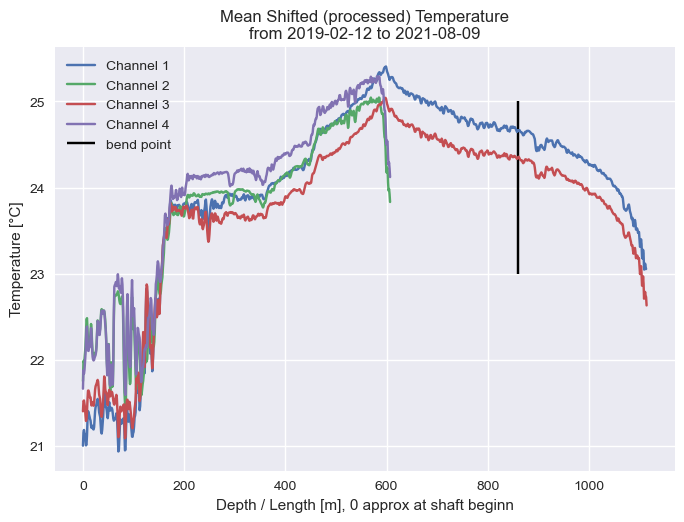

In [97]:
begin_shaft = 200
last_length={}
for channel in ["1","2","3","4"]:
    last_length[channel] = data_ch14_constshifted[channel][data_ch14_constshifted[channel].columns[begin_shaft:]].columns.max() - begin_shaft
    print(f"Channel {channel} shifted, last length {last_length[channel]}")
bend_point=last_length["2"] + (last_length["1"] - last_length["2"]) / 2
print(f"bend point would be at {bend_point}, if assuming the DTS measurements exactly stop at the fibre break")
print("die werte  passen nicht zu S. 48 im Abschlussbericht, da war das DTS Gerät irgendwie anders angeschlossen?")

#Plot shifted data
# shaft variable only contains the data until bottom of shaft
# for chan in ["1","2","3","4"]:
#     plt.plot(shaft[chan].mean(axis=0))
for channel in ["1","2","3","4"]:
    y=data_ch14_constshifted[channel][data_ch14_constshifted[channel].columns[200:]].mean(axis=0).values
    x=data_ch14_constshifted[channel][data_ch14_constshifted[channel].columns[200:]].mean(axis=0).index - 200
    plt.plot(x,y, label=f"Channel {channel}")

plt.vlines([bend_point],23,25,color="black",label="bend point")
plt.legend()
min_date=data_ch14_constshifted[channel][data_ch14_constshifted[channel].columns[200:]].index.min().strftime("%Y-%m-%d")
max_date=data_ch14_constshifted[channel][data_ch14_constshifted[channel].columns[200:]].index.max().strftime("%Y-%m-%d")
plt.title(f"Mean Shifted (processed) Temperature\nfrom {min_date} to {max_date}")
plt.xlabel("Depth / Length [m], 0 approx at shaft beginn")
plt.ylabel("Temperature [°C]")
plt.show()

## Interpretation
* ist knick bei depth 600 realer Temperaturänderung im Schacht? Die kurzen Kabel gehen bis ca. 600. 
    * Dieser Knick ist also bei der selben Tiefe wo das Kabel gebrochen ist. (Aus der Sicht von Channel 1 und 3 ist es auf dem Weg hoch gebrochen). 
* Ist es nicht auch verwunderlich, dass nur zwei der 4 Fasern an der Stelle gebrochen sind? Die anderen werden auch in irgendeinareweise Schaden erlitten haben?!
* Bei ca. 860 geht das Kabel irgendwann wieder hoch, ist aber nicht zu sehen, eigentlich müsste es ja symmetrisch sein ab dem Punkt wo es wieder hochgeht.
* Das der Kabelbruch Punkte von vorher beeinflusst kann eigentlich nicht sein, da das Licht ja noch gar nicht bis zum Kabelbruch gekommen ist. Beschädigungen am Kabel können also nur Punkte die später kommen beeinflussen. Norbert meinte, dass sie auch vorher beieinflussen können muss ich in Literatur noch gucken.
* Bei ca. 0 (shaft begin) sieht man in den backscattered Daten eine Dämpfungsänderrung. Dort wurden Kabel gespleißt??????
* Bei 600 - 608 m sind bei der Kamerabefahrung Seile gefunden worden: ANh01 Fotot 18; Abschlussbericht S. 44
  * war die in der Pegelleitung oder im Schacht?

# Compare Channel 1-4 and Channel 5-8
Here I use the final corrected data for comparisson. The results should be "equal"

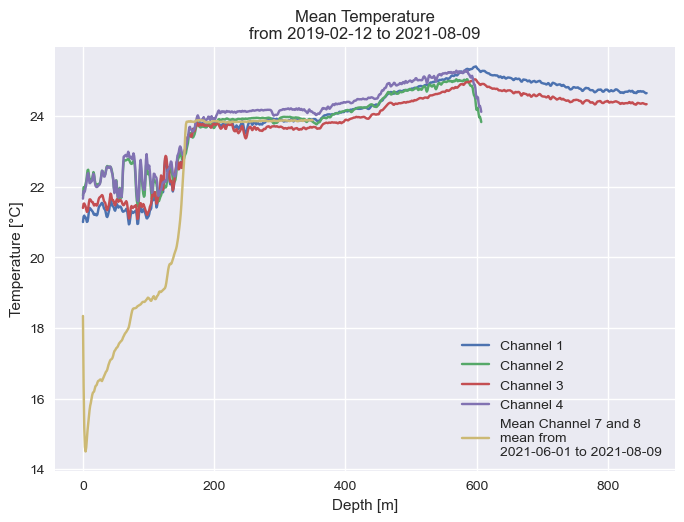

In [98]:
#both datafames have the same number of rows and dates are similar
for chan in ["1","2","3","4"]:
    plt.plot(shaft[chan].mean(axis=0).index,shaft[chan].mean(axis=0).values, label=f"Channel {chan}")

min_date=Schacht_7and8_down.index.min().strftime("%Y-%m-%d")
max_date=Schacht_7and8_down.index.max().strftime("%Y-%m-%d")
plt.plot(Schacht_7and8_down.mean(axis=0).index,Schacht_7and8_down.mean(axis=0).values, label=f"Mean Channel 7 and 8\nmean from \n{min_date} to {max_date}")
plt.legend()
min_date=shaft["2"].index.min().strftime("%Y-%m-%d")
max_date=shaft["2"].index.max().strftime("%Y-%m-%d")
plt.title(f"Mean Temperature\nfrom {min_date} to {max_date}")
plt.xlabel("Depth [m]")
plt.ylabel("Temperature [°C]")
plt.show()

In [99]:
# Calc diff to EGRT cable
channel="3"

data1 = shaft[channel]
data2 = Schacht_7and8_down
date_name, date_iloc = find_nearest_date(data2.iloc[0].name, data1.index) #find out which dates I need from data1
diff_othercable = calc_diff_between_channels(data1[date_iloc:], data2, expected_difference_minutes=15)

diff_statistic = calc_stat_of_difference(diff_othercable["diff_abs"].transpose())

# diese Berechnung könnte ich auch für jeden Channel machen, aber man sieht ja oben, dass das keinen großen Unterschied macht

# Warning später mit beschäftigen

C:\Users\Mathis\Desktop\Masterthesis\Scripts_Masterarbeit\my_func_mvw\functions.py:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_diff_re[date_name_chx] = diff_re
C:\Users\Mathis\Desktop\Masterthesis\Scripts_Masterarbeit\my_func_mvw\functions.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_diff_abs[date_name_chx] = diff_abs
C:\Users\Mathis\Desktop\Masterthesis\Scripts_Masterarbeit\my_func_mvw\functions.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

Warning 2: large time difference
0 days 00:46:02
Warning 1: large time difference
0 days 00:18:00
Warning 1: large time difference
0 days 00:18:01


C:\Users\Mathis\Desktop\Masterthesis\Scripts_Masterarbeit\my_func_mvw\functions.py:213: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(data_array)
C:\Users\Mathis\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [100]:
#px.imshow(diff_othercable["diff"],zmin=-2,zmax=2)

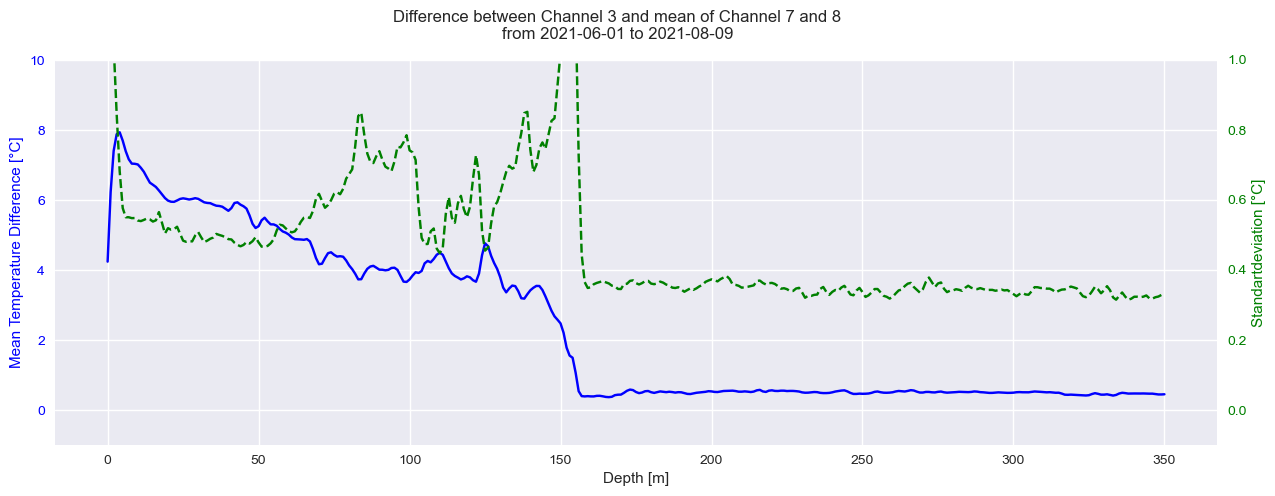

In [101]:
# Plot difference
##########Inputs##########
ymin=-1;ymax=10
cmean="blue";cstdev="green"
lstyle_mean="-";lstyle_stdev="--"
######################
fig,axs=plt.subplots(1,1,figsize=[15,5])#,constrained_layout=True)
min_date=diff_othercable["diff_abs"].columns.min().strftime("%Y-%m-%d")
max_date=diff_othercable["diff_abs"].columns.max().strftime("%Y-%m-%d")
fig.suptitle(f"Difference between Channel {channel} and mean of Channel 7 and 8\nfrom {min_date} to {max_date}")
#fig.tight_layout()

axs.plot(diff_statistic.loc["mean"].index,diff_statistic.loc["mean"].values,label="mean",color=cmean,linestyle=lstyle_mean)#label="Bottom Hole Temperature"
axs.set_xlabel("Depth [m]")
axs.set_ylabel("Mean Temperature Difference [°C]",color=cmean)
axs.set_ylim(ymin,ymax) # both y-axis have similar scale --> helper lines are alligned
axs.tick_params(axis='y', labelcolor=cmean)

axs0_2 = axs.twinx()
axs0_2.plot(diff_statistic.loc["stdev"].index,diff_statistic.loc["stdev"].values,label="stdev",color=cstdev,linestyle=lstyle_stdev) #,label="Salinity")
axs0_2.set_ylabel('Standartdeviation [°C]', color=cstdev)
axs0_2.set_ylim(ymin/10,ymax/10) # both y-axis have similar scale --> helper lines are alligned
axs0_2.tick_params(axis='y', labelcolor=cstdev)
# The grids are not alligned, if not using .set_ylim()
axs0_2.grid(None) #axs is behind the helper lines
plt.show()


* Im Wasser sind sich die Ergebnisse sehr ähnlich. Vorher nicht.
* Die ersten 151.6 m gehen Channel 1-4 durch eine Bohrung im Beton. 
* Channel 5-8 gehen die durch ein anderes Rohr, eine Pegelleitung

# Compare to heat exchanger

In [102]:
# Import heat exchanger operating monitoring
# sek: heating in building (warmer)
# prim: heat exchanger (colder)
xl_file = pd.ExcelFile(path_to_my_database + "\wärmepumpe_betrieb\WP_2018-1019.xlsx")

df_wp_flow = pd.read_excel(xl_file, sheet_name="WP Durchfluss")
df_wp_flow.index=pd.to_datetime(df_wp_flow["Zeitstempel"])
df_wp_flow.sort_index(inplace=True)
df_wp_flow = df_wp_flow.drop(["Zeitstempel","WP_WMZ_sek_Flow"], axis=1)

df_wp_temp = pd.read_excel(xl_file, sheet_name="WP Temperaturen")
df_wp_temp.index=pd.to_datetime(df_wp_temp["Zeitstempel"])
df_wp_temp = df_wp_temp.drop(["Zeitstempel","WP_VL_Temp_Heizseite","WP_RL_Temp_Heizseite"],axis=1)
df_wp_temp.sort_index(inplace=True)

In [103]:
# difference of in and out temperature
# an estimation of how much heat is extracted
df_wp_temp["Difference_VL-RL"] = df_wp_temp["WP_VL_Temp_Soleseite"] - df_wp_temp["WP_RL_Temp_Soleseite"]

In [200]:
sample_hours=1
chan="3"
n_values = 15000  #number of data which is plotted from DTS, not all are needed to compare
for c in ["1","2","3","4"]: #shorten to needed time space
    shaft_nan[c]=shaft[c][:n_values]
shaft_nan_chan = add_nan_val_in_datagaps(shaft_nan[chan])
data_dts_corr=shaft_nan_chan.resample(f"{sample_hours}H").ffill()#.diff()

temp_RL_rolling_corr = df_wp_temp["WP_RL_Temp_Soleseite"].rolling(30,min_periods=5, center = True).mean()[160000:].resample(f"{sample_hours}H").ffill()

temp_RL_rolling_corr=temp_RL_rolling_corr[110:2109]
data_dts_corr=data_dts_corr[300][1:2000]

954 dates with nan have been added


In [201]:
data_dts_corr.corr(temp_RL_rolling_corr)

0.4507927730324323

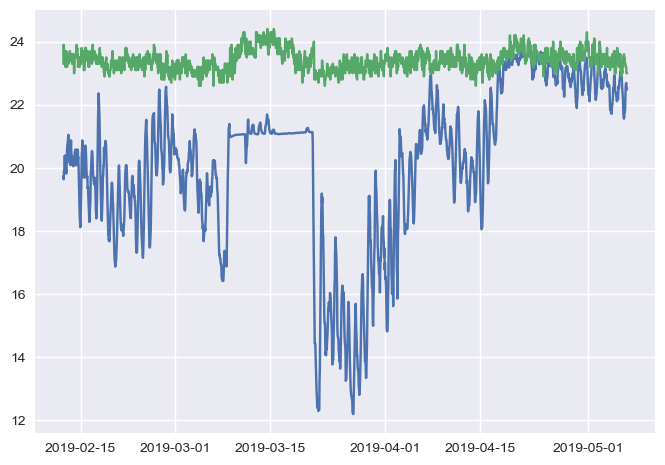

In [202]:
plt.plot(temp_RL_rolling_corr)
plt.plot(data_dts_corr)
plt.show()

954 dates with nan have been added


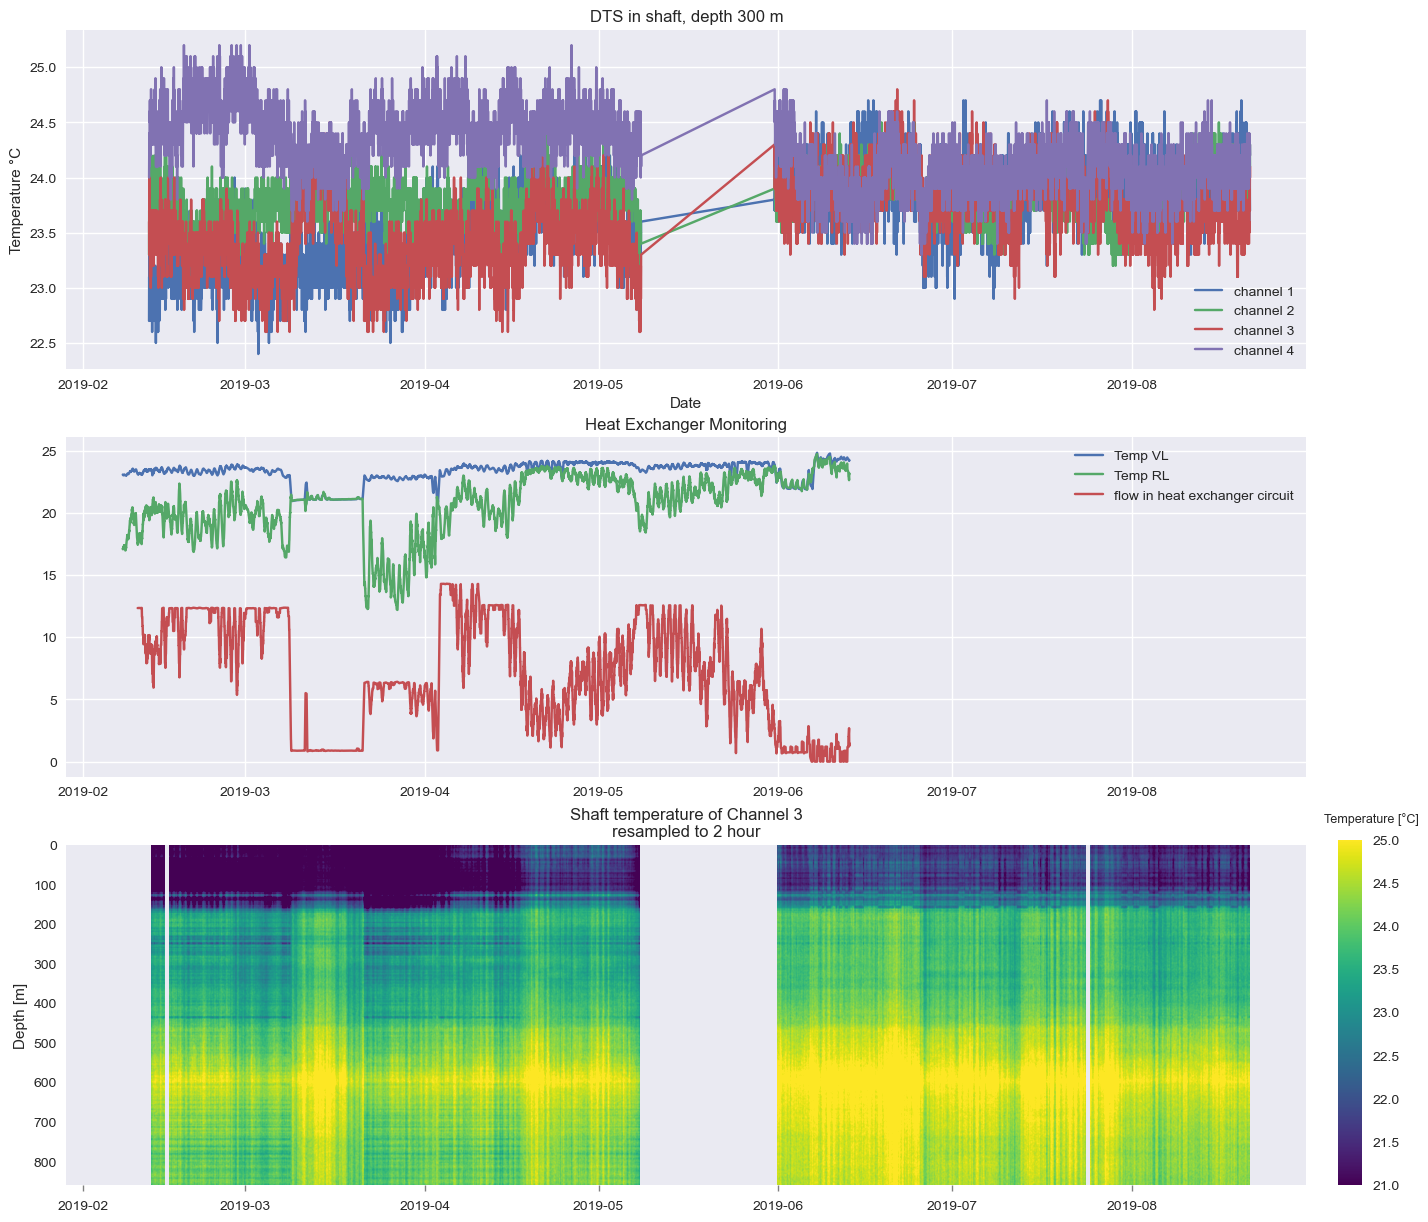

In [218]:
# plot all const shift data compared to heat exchanger monitoring
depth=300

fig, axs = plt.subplots(3,1,figsize=[16,15])

for c in ["1","2","3","4"]:
    inde=shaft[c][depth].index[:n_values]
    val=shaft[c][depth].values[:n_values]
    axs[0].plot(inde,val, label=f"channel {c}")
#axs[0].vlines(pd.to_datetime("2020-11-24 12:00:00"),22,26,color="black",label="Wireline 2020")
#axs[0].plot(df_Tlogger_PT100.index, df_Tlogger_PT100["Channel1-Watertank_PT100"], label="Watertank")

# values before 02.02.2019 are not usable --> skip first values
temp_diff_rolling=df_wp_temp["Difference_VL-RL"].rolling(30,min_periods=5, center = True).mean()[160000:]
temp_VL_rolling = df_wp_temp["WP_VL_Temp_Soleseite"].rolling(30,min_periods=5, center = True).mean()[160000:]
temp_RL_rolling = df_wp_temp["WP_RL_Temp_Soleseite"].rolling(30,min_periods=5, center = True).mean()[160000:]
flow_rolling=df_wp_flow["WP_WMZ_prim_Flow"].rolling(30,min_periods=5, center = True).mean()[29000:]
#axs[1].plot(temp_diff_rolling, label="temp diff in heat exchanger circiut")
axs[1].plot(temp_VL_rolling, label="Temp VL")
axs[1].plot(temp_RL_rolling, label="Temp RL")
axs[1].plot(flow_rolling, label="flow in heat exchanger circuit")

#axs[1].plot(temp_RL_rolling_corr)
#axs[0].plot(data_dts_corr)

axs[0].set_ylabel("Temperature °C")
axs[0].set_xlabel("Date")
axs[0].set_title(f"DTS in shaft, depth {depth} m")
axs[0].legend()
axs[1].set_title("Heat Exchanger Monitoring")
axs[1].legend()
axs[1].sharex(axs[0])

# Carpet Plot
sample_hours=2
vmin=21
vmax=25
chan="3" #change me

shaft_nan={}
n_values = 15000  #number of data which is plotted from DTS, not all are needed to compare
for c in ["1","2","3","4"]: #shorten to needed time space
    shaft_nan[c]=shaft[c][:n_values]
shaft_nan_chan = add_nan_val_in_datagaps(shaft_nan[chan])


data=shaft_nan_chan.resample(f"{sample_hours}H").ffill()#.diff()
depth=data.columns
date = data.index.to_series()
# Datum-Ticks auf x-Achse und Farbskala
starti = depth[0]
stopi = depth[-1]
xax3 = mdates.date2num(date)
xstart = xax3[0]
xstop  = xax3[-1]

axs[2].set_title(f'Shaft temperature of Channel {chan}\nresampled to {sample_hours} hour', fontsize = 12)
axs[2].grid(False) #axs[0,1].grid(color = '#10366f', alpha = 0.1)
caxa = axs[2].imshow(data.transpose(), interpolation = 'gaussian', extent = [xstart, xstop, stopi, starti],
                cmap = 'viridis', aspect = 'auto', vmin = vmin, vmax = vmax)
#PiYG
axs[2].set_ylabel("Depth [m]")
axs[2].tick_params(axis="x", which='both',length=4,color="grey")
cbax = fig.add_axes([0.92, 0.11, 0.015, 0.23])
cbar = fig.colorbar(caxa, cax = cbax, orientation = 'vertical', fraction = 0.05, pad = - 0.05)
cbar.set_label('Temperature [°C]', rotation = 0, fontsize = 9, labelpad = -20,  y = 1.08)
#axs[2].sharex(axs[0])
axs[2].tick_params(axis = 'x', labelrotation = 0)
axs[2].xaxis_date()
date_format = mdates.DateFormatter('%Y-%m-%d')
axs[2].xaxis.set_major_formatter(date_format)
axs[2].sharex(axs[0])

if plot_save:
    plt.savefig("8_heat_exchanger_monitoring_compare_dts.png")
plt.show()

#kanal 3 und 4 zeigen Korreltation zu Rücklauf temperatur (entgegengesetzt)
    #3 wird wärmer bei stopp --> RL
    #4 wird kälter bei stopp --> VL

# kanal 1 und 2 zeigen kaum Änderrungen, wie Vorlauf Temperatur? 
    #Nicht so nah am Rohr, andere Seite im Kabel? die Wasser zugewnat ist?

# somit wären kanal 1 und 4 an einer glasfaser
# 2 und 3 an der anderen

# Analyse Shaft temperature during EGRT

In [105]:
# import solexperts t_logger
path_to_my_database = r"..\Alsdorf\Daten\my_database"
path_to_solexperts = path_to_my_database + "\Solexperts_EGRT"
filename = "\wagoTemperatur_korigiert.txt"
tlogger_sol = pd.read_csv(path_to_solexperts + filename, delimiter="\t", index_col=0)
tlogger_sol.columns.names = ["Dates"]
tlogger_sol.columns= pd.to_datetime(tlogger_sol.columns)
tlogger_sol.index=["Watertank"]
tlogger_sol.index.names = [""]
tlogger_sol = tlogger_sol.T
tlogger_sol.columns = ["Watertank_PT1000"] # name is does not fit to this data, just for concat woth my other dataframe

6 dates with nan have been added
6 dates with nan have been added
6 dates with nan have been added
6 dates with nan have been added


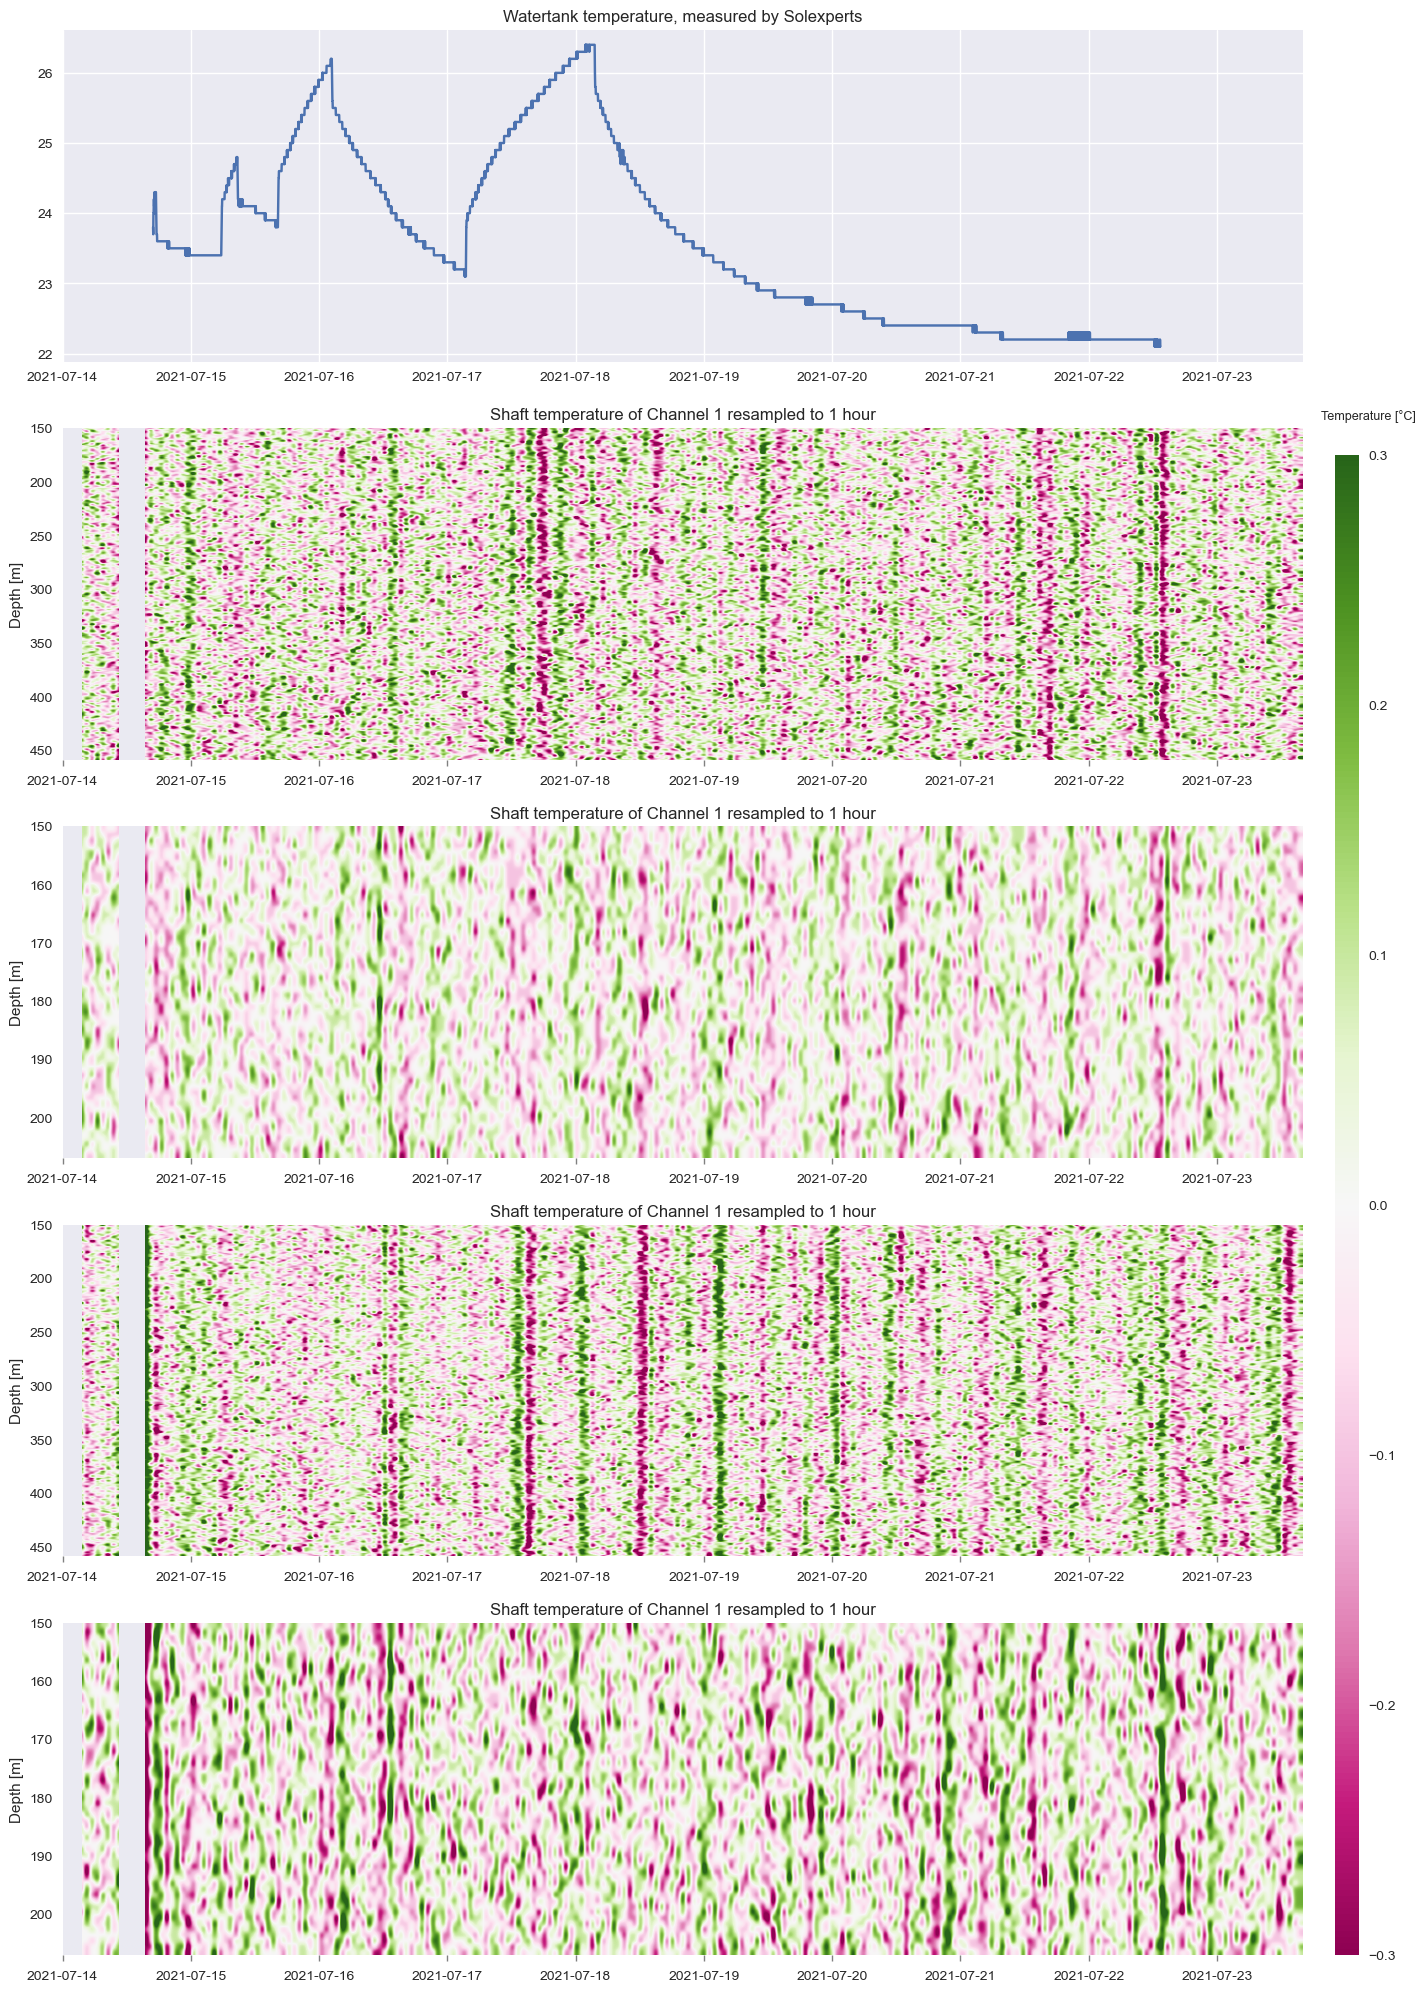

In [139]:
type_plot="diff" #normal diff
plot_where="shaft" #watertank shaft
vmin=22
vmax=26
sample_hours = 1
fig, axs = plt.subplots(5,1,figsize=[16,25])

axs[0].plot(tlogger_sol["Watertank_PT1000"])
axs[0].set_title("Watertank temperature, measured by Solexperts")

for c in ["1","2","3","4"]: #shorten to needed time space
    # in shaft hard to see influence
    if plot_where=="shaft":
        col=shaft[c][61650:62200].columns[150:-400]
        shaft_nan_chan = shaft[c][61650:62200][col]
    
    # water tank heating is visible
    if plot_where=="watertank":
        col=data_ch14_constshifted[c][61650:62200].columns[60:100]
        shaft_nan_chan = data_ch14_constshifted[c][61650:62200][col]
    
    shaft_nan_chan = add_nan_val_in_datagaps(shaft_nan_chan)
    if type_plot=="normal":
        data=shaft_nan_chan.resample(f"{sample_hours}H").ffill()
    if type_plot=="diff":
        data=shaft_nan_chan.resample(f"{sample_hours}H").ffill().diff()
    depth=data.columns
    date = data.index.to_series()
    # Datum-Ticks auf x-Achse und Farbskala
    starti = depth[0]
    stopi = depth[-1]
    xax3 = mdates.date2num(date)
    xstart = xax3[0]
    xstop  = xax3[-1]

    axs[int(c)].set_title(f'Shaft temperature of Channel {chan} resampled to {sample_hours} hour', fontsize = 12)
    axs[int(c)].grid(False) #axs[0,1].grid(color = '#10366f', alpha = 0.1)
    if type_plot=="diff":
        caxa = axs[int(c)].imshow(data.transpose(), interpolation = 'gaussian', extent = [xstart, xstop, stopi, starti],
                        cmap = 'PiYG', aspect = 'auto', vmin = -0.3, vmax = 0.3) 
    if type_plot=="normal":
        caxa = axs[int(c)].imshow(data.transpose(), interpolation = 'gaussian', extent = [xstart, xstop, stopi, starti],
                        cmap = 'viridis', aspect = 'auto', vmin = vmin, vmax = vmax) 
    axs[int(c)].set_ylabel("Depth [m]")
    axs[int(c)].tick_params(axis="x", which='both',length=4,color="grey")
    axs[int(c)].tick_params(axis = 'x', labelrotation = 0)
    axs[int(c)].xaxis_date()
    date_format = mdates.DateFormatter('%Y-%m-%d')
    axs[int(c)].xaxis.set_major_formatter(date_format)
    axs[int(c)].sharex(axs[0])

cbax = fig.add_axes([0.92, 0.11, 0.015, 0.6])
cbar = fig.colorbar(caxa, cax = cbax, orientation = 'vertical', fraction = 0.05, pad = - 0.05)
cbar.set_label('Temperature [°C]', rotation = 0, fontsize = 9, labelpad = -20,  y = 1.03)

if plot_save:
    plt.savefig("9_each_ch14_during_egrt_carpet_diff.png")
plt.show()


# man sieht nichts?
# statistisch analysieren, vieleicht sieht man dann was?
# von jedem Channel min max mean stdev tiefenabhängig über diesen Zeitraum und angucken
# plots unten, man sieht auch nichts würde ich sagen
# Norbert fragen wie das noch besser machen kann damit wir beim nächsten mal besser darüber reden können????

6 dates with nan have been added


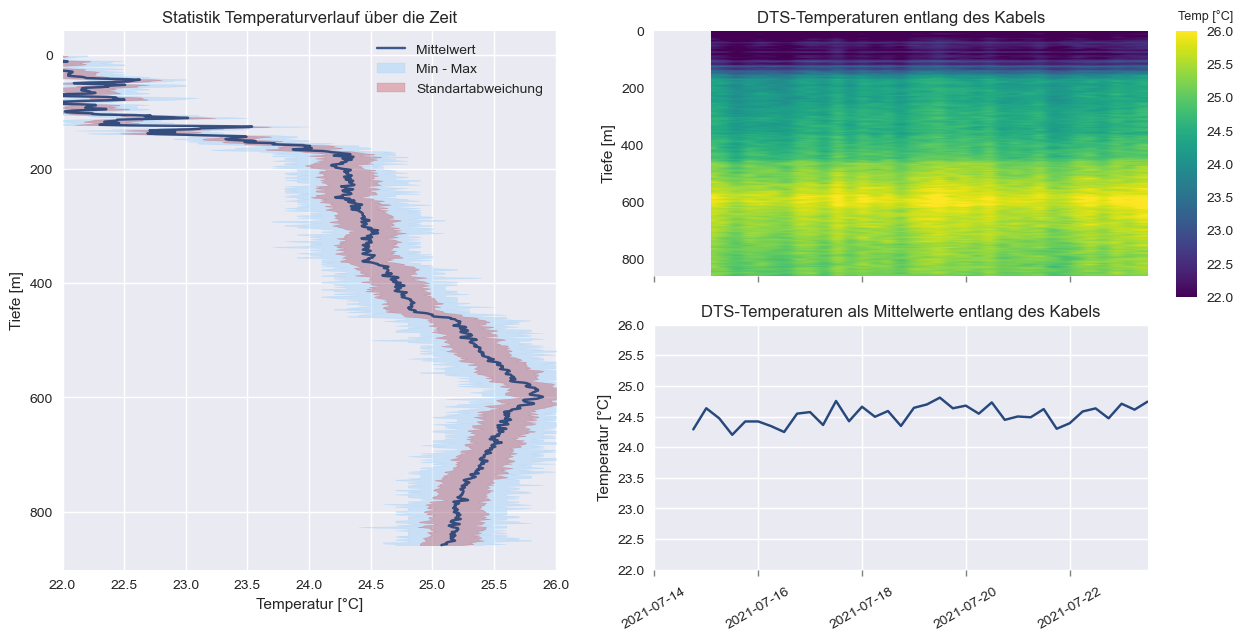

In [108]:
#Date range EGRT
# Copied / Inspired by Daniels plot
header_fontsize=12
c="1"
temp_ax_min=22
temp_ax_max=26
shaft_nan_chan = shaft[c][61650:62200]
shaft_nan_chan = add_nan_val_in_datagaps(shaft_nan_chan)

data_down=shaft_nan_chan.resample(f"{sample_hours}H").ffill()

depth = data_down.columns
# for every depth minimum along all dates

tempmin = data_down.min(axis = 0)
tempmax = data_down.max(axis = 0)
tempmean = data_down.mean(axis = 0)
tempstd = data_down.std(axis = 0)

fig , axs=plt.subplots(2,2,figsize=[14,7]) #, sharey = True #,constrained_layout=True
# Make one axes out of two subplots
gs = axs[1, 0].get_gridspec()
fig.delaxes(axs[0,0])
fig.delaxes(axs[1,0])
big_axs = fig.add_subplot(gs[:, 0])

# 1. Axes
big_axs.set_title('Statistik Temperaturverlauf über die Zeit', fontsize = header_fontsize)
big_axs.plot(tempmean, depth, color='#10366f', alpha = 0.8, label = 'Mittelwert')
big_axs.fill_betweenx(depth, tempmin, tempmax,
                #facecolor="blue",           # The fill color
                color='#7fc7ff',             # The outline color
                alpha=0.3, label = 'Min - Max') # Transparency of the fill
big_axs.fill_betweenx(depth, tempmean - tempstd, tempmean + tempstd,
                # facecolor="#1CB992",       # The fill color
                color="#c52b2f",             # The outline color
                alpha=0.3, label = 'Standartabweichung') # Transparency of the fill

big_axs.set_ylim([(depth.max() + 0.05 * (depth.max()-depth.min())), 
                (depth.min() - 0.05 * (depth.max() - depth.min()))])
big_axs.legend()
big_axs.set_ylabel("Tiefe [m]")
big_axs.set_xlabel("Temperatur [°C]")
big_axs.set_xlim(temp_ax_min,temp_ax_max)

# 2. Axes
date = data_down.index.to_series()
# Datum-Ticks auf x-Achse und Farbskala
starti = depth[0]
stopi = depth[-1]
xax3 = mdates.date2num(date)
xstart = xax3[0]
xstop  = xax3[-1]

axs[0,1].set_title('DTS-Temperaturen entlang des Kabels', fontsize = header_fontsize)
axs[0,1].tick_params(axis = 'x', labelrotation = 30, labelcolor = 'w')
axs[0,1].grid(False) #axs[0,1].grid(color = '#10366f', alpha = 0.1)
caxa = axs[0,1].imshow(data_down.transpose(), interpolation = 'gaussian', extent = [xstart, xstop, stopi, starti],
                 vmin = temp_ax_min, vmax = temp_ax_max, cmap = 'viridis', aspect = 'auto')
cbax = fig.add_axes([0.92, 0.5, 0.015, 0.38])
cbar = fig.colorbar(caxa, cax = cbax, orientation = 'vertical', fraction = 0.05, pad = - 0.05)
cbar.set_label('Temp [°C]', rotation = 0, fontsize = 9, labelpad = -20,  y = 1.08)
axs[0,1].set_ylabel("Tiefe [m]")
#axs[0,1].sharey(big_axs)

# 3. Axes
axs[1,1].set_title('DTS-Temperaturen als Mittelwerte entlang des Kabels', fontsize = header_fontsize)
axs[1,1].set_ylabel('Temperatur [°C]')
axs[1,1].tick_params(axis = 'x', labelrotation = 30)
axs[1,1].set_ylim(temp_ax_min, temp_ax_max)
axs[1,1].plot(data_down.mean(axis = 1), color = '#10366f', alpha = 0.9, label = 'DTS-Temperatur')
axs[1,1].sharex(axs[0,1])
axs[1,1].xaxis_date()
date_format = mdates.DateFormatter('%Y-%m-%d')
axs[1,1].xaxis.set_major_formatter(date_format)

axs[1,1].tick_params(axis="x", which='both',length=4,color="grey")
axs[0,1].tick_params(axis="x", which='both',length=4,color="grey")
plt.savefig("2_test_at_egrt.png")
plt.show()

0 dates with nan have been added


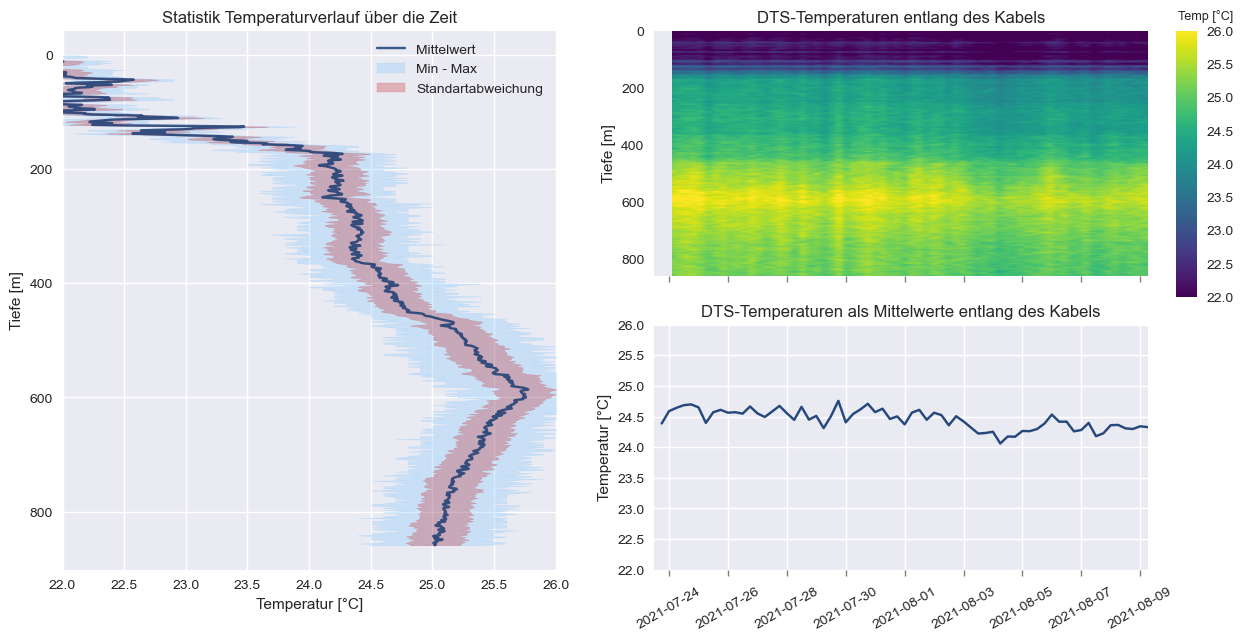

In [109]:
# Compare: Date range after EGRT
# Copied / Inspired by Daniels plot
header_fontsize=12
c="1"
temp_ax_min=22
temp_ax_max=26
shaft_nan_chan = shaft[c][62200:63000]
shaft_nan_chan = add_nan_val_in_datagaps(shaft_nan_chan)

data_down=shaft_nan_chan.resample(f"{sample_hours}H").ffill()

depth = data_down.columns
# for every depth minimum along all dates

tempmin = data_down.min(axis = 0)
tempmax = data_down.max(axis = 0)
tempmean = data_down.mean(axis = 0)
tempstd = data_down.std(axis = 0)

fig , axs=plt.subplots(2,2,figsize=[14,7]) #, sharey = True #,constrained_layout=True
# Make one axes out of two subplots
gs = axs[1, 0].get_gridspec()
fig.delaxes(axs[0,0])
fig.delaxes(axs[1,0])
big_axs = fig.add_subplot(gs[:, 0])

# 1. Axes
big_axs.set_title('Statistik Temperaturverlauf über die Zeit', fontsize = header_fontsize)
big_axs.plot(tempmean, depth, color='#10366f', alpha = 0.8, label = 'Mittelwert')
big_axs.fill_betweenx(depth, tempmin, tempmax,
                #facecolor="blue",           # The fill color
                color='#7fc7ff',             # The outline color
                alpha=0.3, label = 'Min - Max') # Transparency of the fill
big_axs.fill_betweenx(depth, tempmean - tempstd, tempmean + tempstd,
                # facecolor="#1CB992",       # The fill color
                color="#c52b2f",             # The outline color
                alpha=0.3, label = 'Standartabweichung') # Transparency of the fill

big_axs.set_ylim([(depth.max() + 0.05 * (depth.max()-depth.min())), 
                (depth.min() - 0.05 * (depth.max() - depth.min()))])
big_axs.legend()
big_axs.set_ylabel("Tiefe [m]")
big_axs.set_xlabel("Temperatur [°C]")
big_axs.set_xlim(temp_ax_min,temp_ax_max)

# 2. Axes
date = data_down.index.to_series()
# Datum-Ticks auf x-Achse und Farbskala
starti = depth[0]
stopi = depth[-1]
xax3 = mdates.date2num(date)
xstart = xax3[0]
xstop  = xax3[-1]

axs[0,1].set_title('DTS-Temperaturen entlang des Kabels', fontsize = header_fontsize)
axs[0,1].tick_params(axis = 'x', labelrotation = 30, labelcolor = 'w')
axs[0,1].grid(False) #axs[0,1].grid(color = '#10366f', alpha = 0.1)
caxa = axs[0,1].imshow(data_down.transpose(), interpolation = 'gaussian', extent = [xstart, xstop, stopi, starti],
                 vmin = temp_ax_min, vmax = temp_ax_max, cmap = 'viridis', aspect = 'auto')
cbax = fig.add_axes([0.92, 0.5, 0.015, 0.38])
cbar = fig.colorbar(caxa, cax = cbax, orientation = 'vertical', fraction = 0.05, pad = - 0.05)
cbar.set_label('Temp [°C]', rotation = 0, fontsize = 9, labelpad = -20,  y = 1.08)
axs[0,1].set_ylabel("Tiefe [m]")
#axs[0,1].sharey(big_axs)

# 3. Axes
axs[1,1].set_title('DTS-Temperaturen als Mittelwerte entlang des Kabels', fontsize = header_fontsize)
axs[1,1].set_ylabel('Temperatur [°C]')
axs[1,1].tick_params(axis = 'x', labelrotation = 30)
axs[1,1].set_ylim(temp_ax_min, temp_ax_max)
axs[1,1].plot(data_down.mean(axis = 1), color = '#10366f', alpha = 0.9, label = 'DTS-Temperatur')
axs[1,1].sharex(axs[0,1])
axs[1,1].xaxis_date()
date_format = mdates.DateFormatter('%Y-%m-%d')
axs[1,1].xaxis.set_major_formatter(date_format)

axs[1,1].tick_params(axis="x", which='both',length=4,color="grey")
axs[0,1].tick_params(axis="x", which='both',length=4,color="grey")
plt.savefig("3_test_after_egrt.png")
plt.show()

22 dates with nan have been added


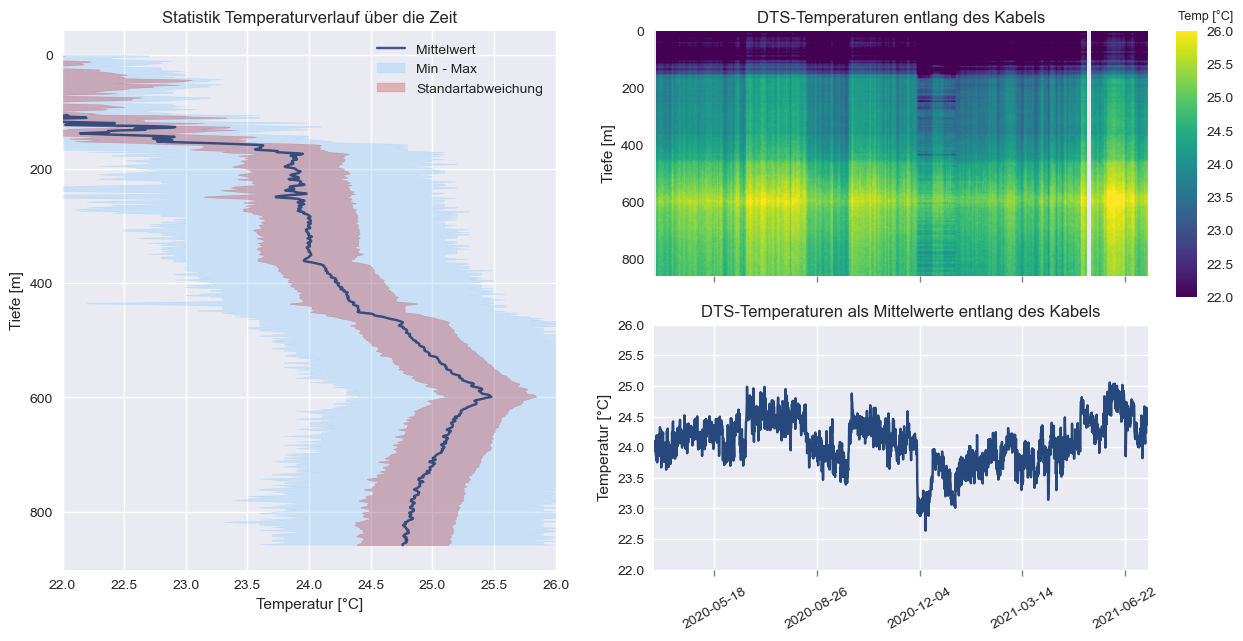

In [110]:
#Date range before EGRT
# Copied / Inspired by Daniels plot
header_fontsize=12
c="1"
temp_ax_min=22
temp_ax_max=26
shaft_nan_chan = shaft[c][20400:61650]#[61000:61650]##
shaft_nan_chan = add_nan_val_in_datagaps(shaft_nan_chan)

data_down=shaft_nan_chan.resample(f"{sample_hours}H").ffill()

depth = data_down.columns
# for every depth minimum along all dates

tempmin = data_down.min(axis = 0)
tempmax = data_down.max(axis = 0)
tempmean = data_down.mean(axis = 0)
tempstd = data_down.std(axis = 0)

fig , axs=plt.subplots(2,2,figsize=[14,7]) #, sharey = True #,constrained_layout=True
# Make one axes out of two subplots
gs = axs[1, 0].get_gridspec()
fig.delaxes(axs[0,0])
fig.delaxes(axs[1,0])
big_axs = fig.add_subplot(gs[:, 0])

# 1. Axes
big_axs.set_title('Statistik Temperaturverlauf über die Zeit', fontsize = header_fontsize)
big_axs.plot(tempmean, depth, color='#10366f', alpha = 0.8, label = 'Mittelwert')
big_axs.fill_betweenx(depth, tempmin, tempmax,
                #facecolor="blue",           # The fill color
                color='#7fc7ff',             # The outline color
                alpha=0.3, label = 'Min - Max') # Transparency of the fill
big_axs.fill_betweenx(depth, tempmean - tempstd, tempmean + tempstd,
                # facecolor="#1CB992",       # The fill color
                color="#c52b2f",             # The outline color
                alpha=0.3, label = 'Standartabweichung') # Transparency of the fill

big_axs.set_ylim([(depth.max() + 0.05 * (depth.max()-depth.min())), 
                (depth.min() - 0.05 * (depth.max() - depth.min()))])
big_axs.legend()
big_axs.set_ylabel("Tiefe [m]")
big_axs.set_xlabel("Temperatur [°C]")
big_axs.set_xlim(temp_ax_min,temp_ax_max)

# 2. Axes
date = data_down.index.to_series()
# Datum-Ticks auf x-Achse und Farbskala
starti = depth[0]
stopi = depth[-1]
xax3 = mdates.date2num(date)
xstart = xax3[0]
xstop  = xax3[-1]

axs[0,1].set_title('DTS-Temperaturen entlang des Kabels', fontsize = header_fontsize)
axs[0,1].tick_params(axis = 'x', labelrotation = 30, labelcolor = 'w')
axs[0,1].grid(False) #axs[0,1].grid(color = '#10366f', alpha = 0.1)
caxa = axs[0,1].imshow(data_down.transpose(), interpolation = 'gaussian', extent = [xstart, xstop, stopi, starti],
                 vmin = temp_ax_min, vmax = temp_ax_max, cmap = 'viridis', aspect = 'auto')
cbax = fig.add_axes([0.92, 0.5, 0.015, 0.38])
cbar = fig.colorbar(caxa, cax = cbax, orientation = 'vertical', fraction = 0.05, pad = - 0.05)
cbar.set_label('Temp [°C]', rotation = 0, fontsize = 9, labelpad = -20,  y = 1.08)
axs[0,1].set_ylabel("Tiefe [m]")
#axs[0,1].sharey(big_axs)

# 3. Axes
axs[1,1].set_title('DTS-Temperaturen als Mittelwerte entlang des Kabels', fontsize = header_fontsize)
axs[1,1].set_ylabel('Temperatur [°C]')
axs[1,1].tick_params(axis = 'x', labelrotation = 30)
axs[1,1].set_ylim(temp_ax_min, temp_ax_max)
axs[1,1].plot(data_down.mean(axis = 1), color = '#10366f', alpha = 0.9, label = 'DTS-Temperatur')
axs[1,1].sharex(axs[0,1])
axs[1,1].xaxis_date()
date_format = mdates.DateFormatter('%Y-%m-%d')
axs[1,1].xaxis.set_major_formatter(date_format)

axs[1,1].tick_params(axis="x", which='both',length=4,color="grey")
axs[0,1].tick_params(axis="x", which='both',length=4,color="grey")

plt.savefig("1_test_before_egrt.png")
plt.show()

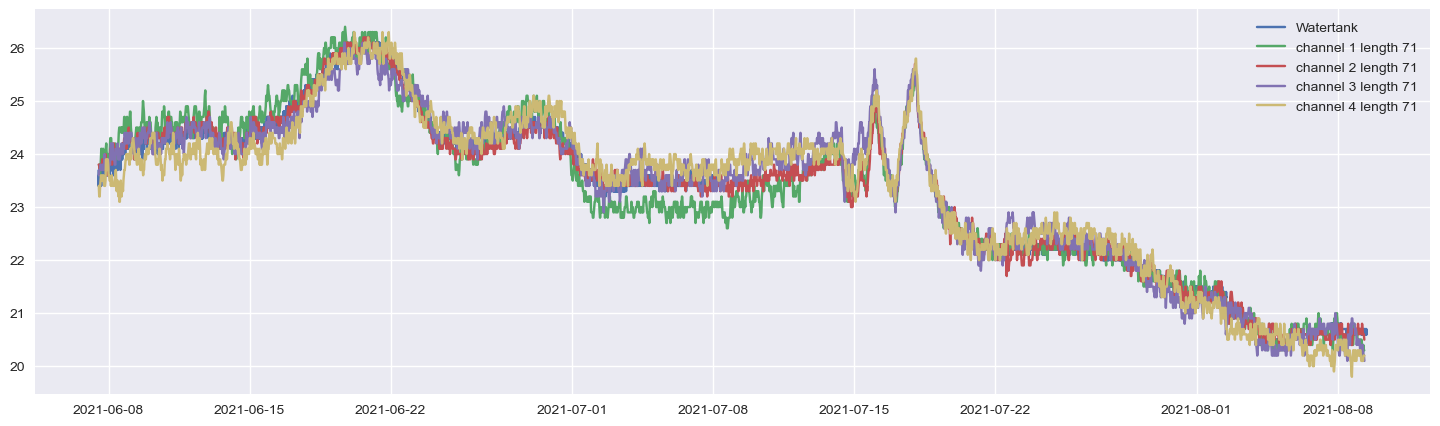

In [111]:
# Compare watertank to channels
# to find where the watertank position is
watertank = 71 

plt.figure(figsize=(18,5))
plt.plot(df_Tlogger_PT100.index, df_Tlogger_PT100["Channel1-Watertank_PT100"], label="Watertank")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["1","2","3","4"]: 
    inde=data_ch14_constshifted[c][str(df_Tlogger_PT100.index.min()) : str(df_Tlogger_PT100.index.max())][watertank].index
    val=data_ch14_constshifted[c][str(df_Tlogger_PT100.index.min()) : str(df_Tlogger_PT100.index.max())][watertank].values
    plt.plot(inde,val, label=f"channel {c} length {watertank}")

plt.legend()
plt.show()